# Veri Yoğun Uygulamalar Modül Projesi: Zaman Serisi Sınıflandırma Problemi

-- Hazırlayan: Eda Nur ARSLAN

----------
## **1. Giriş**
### **1.1 Proje Amacı**
Bu proje, belirli zaman dilimlerine ait hisse senedi kapanış fiyatlarını kullanarak sektör bazlı sınıflandırma yapmayı amaçlamaktadır. Temel hedef, yeni bir hissenin hangi sektöre daha yakın olduğunu belirlemek ve sektörel benzerlik analizi gerçekleştirmektir.

### **1.2 Kullanılan Veri Setleri**
Projede kullanılan veri setleri finans, sağlık ve teknoloji sektörlerindeki 2005 yılından itibaren toplanmış hisse kapanış fiyatlarını içermektedir. Bu veriler Yahoo Finance gibi finansal veri sağlayıcılardan elde edilmiştir.

### **1.3 Modelin Çalışma Prensibi**
Projede, zaman serisi verilerinden elde edilen öznitelikler ile XGBoost, Random Forest ve Gradient Boosting gibi makine öğrenimi algoritmaları kullanılarak sektör tahmini yapılmıştır. Özellikle XGBoost modeli hiperparametre optimizasyonu ile en yüksek doğruluğa ulaşmıştır.


## **2. Veri Hazırlama ve Özellik Mühendisliği**

### **2.1 Ham Verilerin İşlenmesi**
Hisse kapanış fiyatları belirlenen sektörler için toplandı ve aylık kapanış verilerine indirildi. Eksik veriler, ileri ve geri doldurma (forward fill, backward fill, interpolatation) yöntemleri ile tamamlandı.

### **2.2 TSFresh ile Özellik Çıkarımı**
TSFresh kütüphanesi kullanılarak zaman serisi verilerinden önemli öznitelikler türetildi. Hesaplanan öznitelikler arasında şunlar bulunmaktadır:
- **Momentum**: 10 günlük getiri yüzdesi
- **Volatilite**: 30 günlük standart sapma
- **RSI (Relative Strength Index)**
- **MACD (Moving Average Convergence Divergence)**
- **Hareketli Ortalamalar (SMA 50 & SMA 200)**

Öznitelik mühendisliği aşamasında hesaplanan özellikler normalleştirildi ve eksik veriler doldurularak model eğitimi için hazır hale getirildi.


In [ ]:
import yfinance
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO

def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

In [ ]:
sectors=fetch_sectors_names()

In [ ]:
fetch_data(sectors='energy').to_csv("energy.csv", index=False)
fetch_data(sectors='financials').to_csv("financials.csv", index=False)
fetch_data(sectors='healthcare').to_csv("healthcare.csv", index=False)
fetch_data(sectors='technology').to_csv("technology.csv", index=False)
fetch_data(sectors='utilities').to_csv("utilities.csv", index=False)
fetch_data(sectors='real-estate').to_csv("real-estate.csv", index=False)
fetch_data(sectors='materials').to_csv("materials.csv", index=False)
fetch_data(sectors='technology').to_csv("technology.csv", index=False)
fetch_data(sectors='industrials').to_csv("industrials.csv", index=False)
fetch_data(sectors='consumer-staples').to_csv("consumer-staples.csv", index=False)
fetch_data(sectors='consumer-discretionary').to_csv("consumer-discretionary.csv", index=False)
fetch_data(sectors='communication-services').to_csv("communication-services.csv", index=False)

#Veri Çekme
- Şirketlerin çekilmesi
- Şirketlerin aylık getirilerinin çekilmesi

In [ ]:
#Her sektörden 500'er şirket seçme
sector_files = {
    "financials": "financials.csv",
    "healthcare": "healthcare.csv",
    "technology": "technology.csv"
}

selected_stocks = {}

for sector, file in sector_files.items():
    df = pd.read_csv(file)

    # Eğer 500'den fazla şirket varsa rastgele 500 şirket seçelim
    if len(df) >= 500:
        selected_stocks[sector] = df.sample(n=500, random_state=42)
    else:
        selected_stocks[sector] = df  # Eğer 500'den az şirket varsa tümünü al

    # Yeni dosya olarak kaydetme
    selected_stocks[sector].to_csv(f"selected_{sector}.csv", index=False)

In [ ]:
import time

#Aylık Getirileri Güvenli Şekilde Çekme Fonksiyonu
def get_monthly_returns_batched(ticker_list, start_date="2005-01-01", batch_size=50):
    """
    Hisse senedi verilerini parça parça çekerek YFinance API limitlerine takılmaktan kaçınır.
    - API limitlerine takılmamak için batch olarak (küçük gruplar halinde) veri çeker.
    - Borsa dışına çıkmış (delisted) şirketleri tespit eder ve hariç tutar.
    - Eksik verileri interpolate() ile doldurur.
    """
    all_data = []
    failed_tickers = []

    for i in range(0, len(ticker_list), batch_size):
        batch = ticker_list[i:i+batch_size]
        try:
            data = yf.download(batch, start=start_date, interval="1mo")["Close"]
            if data is not None and not data.empty:
                all_data.append(data)
            else:
                failed_tickers.extend(batch)
        except Exception as e:
            print(f"Hata: {e}")
            failed_tickers.extend(batch)

        time.sleep(10)  # API limitine takılmamak için bekleme süresi

    if all_data:
        full_data = pd.concat(all_data, axis=1)
        monthly_returns = full_data.interpolate().ffill().bfill()
        return monthly_returns, failed_tickers
    else:
        return None, failed_tickers

#Seçilen Şirketlerden Aylık Getirileri Çekme
selected_stocks = {
    "financials": pd.read_csv("selected_financials.csv"),
    "healthcare": pd.read_csv("selected_healthcare.csv"),
    #"technology": pd.read_csv("selected_technology.csv"),
}

for sector, df in selected_stocks.items():
    tickers = df["Symbol"].tolist()[:500]  # İlk 500 şirketi al
    sector_returns, failed_tickers = get_monthly_returns_batched(tickers)

    if sector_returns is not None:
        file_path = f"{sector}_monthly_returns.csv"
        sector_returns.to_csv(file_path)

    if failed_tickers:
        print(f"{sector} sektöründe {len(failed_tickers)} şirketin verisi bulunamadı: {failed_tickers}")

📡 Veri çekiliyor: ['BNS', 'TOP', 'PCSC', 'MKTW', 'TIRX', 'FVN', 'SASR', 'TSLX', 'EWBC', 'FUFU', 'FNB', 'WTW', 'VEL', 'CFSB', 'BBAR', 'RMBI', 'HTBK', 'CWBC', 'INTR', 'PBFS', 'DB', 'SEZL', 'LEGT', 'GRAF', 'OWL', 'AX', 'BHB', 'CBNK', 'BUR', 'IBN', 'BN', 'HYAC', 'BSBK', 'RJF', 'ERIE', 'BMO', 'SOS', 'VLY', 'BFH', 'LU', 'SPNT', 'FCNCA', 'BOWN', 'CAPN', 'AGM', 'BWB', 'OVLY', 'BZAI', 'WSFS', 'NTB']


[*********************100%***********************]  50 of 50 completed


📡 Veri çekiliyor: ['WBS', 'CCB', 'BWFG', 'GECC', 'WULF', 'THG', 'WTBA', 'BRBS', 'TURN', 'SFNC', 'CRD.B', 'RVSB', 'WRLD', 'FRBA', 'AEG', 'BAYA', 'MLAC', 'LX', 'PX', 'HBAN', 'STEL', 'SFBS', 'MCBS', 'WTM', 'EQH', 'SAFT', 'EFSC', 'USCB', 'SLQT', 'AFG', 'PAX', 'NWBI', 'PIPR', 'FNWB', 'IROH', 'SBCF', 'BSAC', 'SRCE', 'MKDW', 'PTMN', 'JXN', 'TSBK', 'BAFN', 'LMFA', 'INDB', 'FBNC', 'PRA', 'NSTS', 'FISI', 'RM']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CRD.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[                       0%                       ]

📡 Veri çekiliyor: ['SCM', 'UNTY', 'MPB', 'LPAA', 'GLRE', 'IFS', 'MSCI', 'COFS', 'HONE', 'OACC', 'WABC', 'PRU', 'CLRC', 'JHG', 'TAVI', 'FITB', 'BBUC', 'PFLT', 'JMSB', 'OPOF', 'MBIN', 'HMST', 'TYG', 'RRBI', 'TCBX', 'JACS.RT', 'OBT', 'BWIN', 'MET', 'GDST', 'ATMC', 'CURR', 'TBBK', 'PAPL', 'BOW', 'SBXD', 'AON', 'CME', 'WASH', 'AAMI', 'RFAC', 'AGO', 'SHG', 'TW', 'CPBI', 'EZPW', 'MKL', 'CASH', 'BFST', 'PWP']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JACS.RT']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[                       0%                       ]

📡 Veri çekiliyor: ['PFX', 'HTH', 'TCBS', 'WFC', 'MFC', 'TCBI', 'HTBI', 'STC', 'ALRS', 'BBD', 'OAKU', 'BCG', 'SWIN', 'BKHA', 'GCBC', 'ICE', 'IBKR', 'HSBC', 'EARN', 'RANG', 'ESGR', 'HSPT', 'MORN', 'AMSF', 'GBLI', 'MCO', 'HTGC', 'MVBF', 'CCAP', 'OCSL', 'RBCAA', 'RKT', 'ARBK', 'OBK', 'PKBK', 'FACT', 'AUBN', 'BVFL', 'GCMG', 'HRZN', 'CNF', 'NCTY', 'GATE', 'CNOB', 'PFIS', 'PFBC', 'LPRO', 'CHAR', 'SSBI', 'MBWM']


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

📡 Veri çekiliyor: ['FBK', 'GS', 'MCVT', 'WF', 'BFC', 'OPRT', 'PFG', 'FFIN', 'OPHC', 'NTWO', 'FBMS', 'UCB', 'ISTR', 'RWAY', 'V', 'CHEB', 'CCIX', 'HGTY', 'GLAD', 'SNV', 'BSRR', 'DMYY', 'FLIC', 'GSBC', 'MBCN', 'HBNC', 'CZNC', 'MTAL', 'HOPE', 'NAVI', 'ZBAO', 'CZWI', 'DNB', 'OPY', 'STT', 'HLNE', 'JVSA', 'LYG', 'COLA', 'ABL', 'RENE', 'QD', 'SBFG', 'BEN', 'UFCS', 'MKTX', 'ALF', 'AMP', 'GSRT', 'MRCC']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['COLA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


📡 Veri çekiliyor: ['MBI', 'OXBR', 'FNLC', 'GSIW', 'HWC', 'FDBC', 'MOFG', 'PROV', 'BTBT', 'SDIG', 'EQBK', 'EIG', 'FSUN', 'BMA', 'VINP', 'DBRG', 'HMN', 'FTII', 'CBOE', 'DECA', 'CADE', 'RAND', 'SLF', 'EVR', 'GLBZ', 'CRD.A', 'SSB', 'PB', 'APO', 'PSBD', 'COLB', 'CIFR', 'ASRV', 'RELI', 'BNT', 'COOP', 'MS', 'WHF', 'EBTC', 'HIG', 'SVCC', 'ROOT', 'PLMK', 'FRHC', 'SNEX', 'BGC', 'NMFC', 'FDSB', 'AIZ', 'ORRF']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['CRD.A', 'SVCC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


📡 Veri çekiliyor: ['OMCC', 'GLAC', 'MFG', 'SAR', 'BSBR', 'CPF', 'ING', 'MFIC', 'GSBD', 'SPHA', 'TD', 'DCOM', 'TDAC', 'CAC', 'TRV', 'PCB', 'CLST', 'CBFV', 'NMIH', 'IBCP', 'IBAC', 'VCIC', 'TBNK', 'MUFG', 'ESSA', 'HPH', 'SYF', 'AIG', 'TOWN', 'RNST', 'AQU', 'CCBG', 'SPGI', 'MTG', 'SII', 'BEAG', 'CNO', 'WDH', 'PWOD', 'PFC', 'FMBH', 'CARE', 'OVBC', 'OMF', 'FRST', 'NOAH', 'STEP', 'FIBK', 'HFBL', 'ICCH']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TDAC']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[                       0%                       ]

📡 Veri çekiliyor: ['BRO', 'ARCC', 'PNNT', 'FMNB', 'CG', 'BAP', 'HCI', 'NTRS', 'NFBK', 'TPG', 'SUPV', 'AAM', 'ALCY', 'BLAC', 'MBAV', 'ACNB', 'PUK', 'RY', 'PLBC', 'BBVA', 'NU', 'NBHC', 'BPOP', 'IROQ', 'GOCO', 'FSFG', 'DGICB', 'UPST', 'VBFC', 'NECB', 'FAF', 'DRDB', 'WHG', 'NOEM', 'TMP', 'BKU', 'BTCS', 'STBA', 'HRTG', 'HDB', 'MA', 'BUJA', 'CLSK', 'BETR', 'BPRN', 'NBBK', 'SLRC', 'KMPR', 'GDOT', 'ESQ']


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

📡 Veri çekiliyor: ['AAME', 'FCF', 'FCAP', 'BX', 'FBP', 'UBS', 'VRTS', 'CNS', 'LNKB', 'FGMC', 'BSLK', 'BSVN', 'VBTX', 'EVGR', 'ITIC', 'UBSI', 'TFSL', 'KB', 'SHFS', 'HAFC', 'IPXX', 'WSBC', 'SLM', 'AFBI', 'POLE', 'WTFC', 'FCNCO', 'FFNW', 'CIVB', 'FRME', 'ACGL', 'ONIT', 'MC', 'BANC', 'BSII', 'NEWT', 'EBC', 'WRB', 'LSBK', 'EG', 'RNR', 'RIBB', 'NBTB', 'FULT', 'BRK.B', 'DXF', 'TREE', 'CWD', 'NBN', 'BMRC']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['RIBB', 'BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['FGMC']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
[                       0%                       ]

📡 Veri çekiliyor: ['FHN', 'PFS', 'HCVI', 'FUTU', 'AB', 'EVBN', 'WNEB', 'CCIR', 'AIFU', 'LMND', 'TFIN', 'YOTA', 'CIB', 'HWBK', 'RBB', 'BCOW', 'MACI', 'CSWC', 'MCY', 'NWFL', 'HUT', 'TIPT', 'FIHL', 'QCRH', 'BK', 'CET', 'BCSF', 'SFST', 'ENVA', 'GBCI', 'BENF', 'HNNA', 'FDS', 'DFS', 'VABK', 'PLMR', 'HIT', 'KEY', 'AMRK', 'FUNC', 'GBBK', 'LCNB', 'BOKF', 'LNC', 'SKWD', 'HBCP', 'HOOD', 'ZBAI', 'ORI', 'HLI']


[*********************100%***********************]  50 of 50 completed


✅ financials sektörüne ait aylık kapanış fiyatları kaydedildi!
📡 Veri çekiliyor: ['CRVO', 'BIO.B', 'BLUE', 'EDIT', 'ENZ', 'WGS', 'MRNS', 'PHG', 'CTKB', 'IRON', 'RNTX', 'CRNX', 'ME', 'AMN', 'BNTC', 'MOVE', 'PLUR', 'CRBP', 'NKGN', 'BTSG', 'BHVN', 'ENVB', 'VCYT', 'ZOM', 'MLSS', 'RNAC', 'OBIO', 'GKOS', 'AURA', 'CBUS', 'VMD', 'HCA', 'URGN', 'RGLS', 'CPIX', 'CRVS', 'FOXO', 'KALA', 'CERT', 'MBOT', 'RVMD', 'LXRX', 'TNXP', 'ANNX', 'UPB', 'AMLX', 'PBM', 'CTXR', 'QDEL', 'AUNA']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
11 Failed downloads:
ERROR:yfinance:['BIO.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1mo 2005-01-01 -> 2025-02-10)')
ERROR:yfinance:['TNXP', 'VCYT', 'ANNX', 'CTXR', 'ZOM', 'CRVO', 'CTKB', 'QDEL', 'PLUR', 'GKOS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


📡 Veri çekiliyor: ['PRQR', 'SDGR', 'SLP', 'DNA', 'SMMT', 'AVGR', 'ARAY', 'GCTK', 'VTGN', 'BKD', 'CODX', 'HUM', 'SNDA', 'OCS', 'VTAK', 'CELU', 'SLN', 'OPK', 'GMED', 'ZCMD', 'ANIK', 'ONC', 'IVVD', 'IMCR', 'VKTX', 'SEER', 'VOR', 'DBVT', 'PACB', 'WBA', 'NNOX', 'BVS', 'VINC', 'CNTA', 'LH', 'PTIX', 'OGI', 'MRSN', 'DXR', 'LTRN', 'FONR', 'NVCR', 'THRD', 'PTN', 'ARMP', 'LUCY', 'AUTL', 'KNSA', 'ZIMV', 'IBRX']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
50 Failed downloads:
ERROR:yfinance:['VTGN', 'PTIX', 'SEER', 'SMMT', 'DBVT', 'CELU', 'SNDA', 'NNOX', 'ZIMV', 'PACB', 'LH', 'IVVD', 'LTRN', 'CNTA', 'AVGR', 'AUTL', 'CODX', 'PTN', 'VOR', 'IMCR', 'ONC', 'DNA', 'ZCMD', 'DXR', 'KNSA', 'PRQR', 'FONR', 'SDGR', 'NVCR', 'ANIK', 'IBRX', 'GMED', 'BVS', 'SLN', 'BKD', 'VKTX', 'WBA', 'THRD', 'OCS', 'SLP', 'ARAY', 'ARMP', 'GCTK', 'HUM', 'LUCY', 'VTAK', 'VINC', 'OPK', 'MRSN', 'OGI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


📡 Veri çekiliyor: ['NSYS', 'SGMT', 'ADIL', 'MAZE', 'TMCI', 'BCAX', 'BCRX', 'ATXS', 'PRTC', 'TNON', 'OSTX', 'SCYX', 'SNDX', 'ZURA', 'KTTA', 'PEN', 'PTCT', 'SNSE', 'ALC', 'FENC', 'PSTV', 'MNDR', 'VRNA', 'VNRX', 'GBIO', 'TLX', 'TRDA', 'JSPR', 'RDY', 'ARWR', 'CYTH', 'INM', 'MNKD', 'LSB', 'KAPA', 'CAPR', 'SLRX', 'LIPO', 'NRC', 'NVS', 'ECOR', 'OPT', 'ARQT', 'TEVA', 'TOVX', 'CTMX', 'RCEL', 'STRR', 'ADAP', 'MOLN']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
50 Failed downloads:
ERROR:yfinance:['INM', 'TNON', 'NVS', 'PEN', 'SNDX', 'CTMX', 'OSTX', 'ADAP', 'FENC', 'SCYX', 'PRTC', 'GBIO', 'ATXS', 'ARWR', 'TOVX', 'MAZE', 'SGMT', 'LIPO', 'KTTA', 'BCAX', 'ARQT', 'RCEL', 'ALC', 'KAPA', 'OPT', 'JSPR', 'STRR', 'LSB', 'VRNA', 'CYTH', 'TLX', 'NSYS', 'VNRX', 'MOLN', 'TRDA', 'MNDR', 'BCRX', 'SNSE', 'TEVA', 'ECOR', 'SLRX', 'ADIL', 'PSTV', 'TMCI', 'ZURA', 'RDY', 'MNKD', 'CAPR', 'NRC', 'PTCT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


📡 Veri çekiliyor: ['RBOT', 'NVNO', 'ANIP', 'TMDX', 'ETON', 'CALC', 'SNOA', 'ABEO', 'SENS', 'MHUA', 'GOSS', 'JYNT', 'DTIL', 'COLL', 'TKNO', 'AXDX', 'PHAT', 'UHS', 'NDRA', 'INBX', 'NRIX', 'INDP', 'MYNZ', 'UBX', 'PRTA', 'SLRN', 'ARTV', 'SNYR', 'AFMD', 'ELEV', 'AHCO', 'ITCI', 'TARA', 'CYTK', 'FTRE', 'AGEN', 'IRIX', 'OPTN', 'ITGR', 'OTRK', 'PNTG', 'KRON', 'IONS', 'NEPH', 'ACHL', 'PYPD', 'INCR', 'TLSI', 'INDV', 'GDRX']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
50 Failed downloads:
ERROR:yfinance:['CYTK', 'AXDX', 'PYPD', 'SENS', 'KRON', 'ARTV', 'MHUA', 'CALC', 'FTRE', 'IRIX', 'ANIP', 'JYNT', 'TMDX', 'MYNZ', 'NVNO', 'ABEO', 'INDP', 'OPTN', 'PRTA', 'NEPH', 'NRIX', 'AFMD', 'INBX', 'SNYR', 'UHS', 'AGEN', 'IONS', 'GOSS', 'GDRX', 'TARA', 'INCR', 'UBX', 'SNOA', 'OTRK', 'ITGR', 'ELEV', 'COLL', 'NDRA', 'INDV', 'TLSI', 'PHAT', 'ITCI', 'PNTG', 'ETON', 'TKNO', 'RBOT', 'ACHL', 'DTIL', 'AHCO', 'SLRN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


📡 Veri çekiliyor: ['ORIC', 'DXCM', 'TBPH', 'CLOV', 'SPOK', 'NMRA', 'RDHL', 'CATX', 'ATLN', 'DNLI', 'AVNS', 'MTSR', 'ATRC', 'EVH', 'OKUR', 'ZYXI', 'INCY', 'AORT', 'AKTX', 'FGEN', 'VRPX', 'EBS', 'RVPH', 'ACTU', 'NAMS', 'ALXO', 'IDXX', 'COR', 'DRIO', 'OPCH', 'STE', 'MTVA', 'NUVB', 'WEAV', 'VVOS', 'IVA', 'EKSO', 'TTNP', 'JNJ', 'ACRS', 'RAPT', 'EMBC', 'VERO', 'FBLG', 'MDAI', 'WOK', 'REPL', 'ATYR', 'GOVX', 'NRXP']


[*********************100%***********************]  50 of 50 completed
ERROR:yfinance:
50 Failed downloads:
ERROR:yfinance:['AKTX', 'ATRC', 'ORIC', 'SPOK', 'OPCH', 'VRPX', 'IDXX', 'DRIO', 'ALXO', 'TTNP', 'TBPH', 'WOK', 'EVH', 'VERO', 'AORT', 'GOVX', 'MTSR', 'COR', 'ACRS', 'ATYR', 'OKUR', 'CATX', 'AVNS', 'REPL', 'VVOS', 'ATLN', 'FGEN', 'INCY', 'NUVB', 'CLOV', 'RAPT', 'MDAI', 'NRXP', 'FBLG', 'EKSO', 'EMBC', 'RVPH', 'DNLI', 'NMRA', 'MTVA', 'WEAV', 'EBS', 'DXCM', 'IVA', 'JNJ', 'NAMS', 'RDHL', 'STE', 'ACTU', 'ZYXI']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


📡 Veri çekiliyor: ['ZBH', 'ISPC', 'DAWN', 'CERS', 'ILMN', 'PRPO', 'SPRY', 'GANX', 'EXEL', 'GLSI', 'SAGE', 'AZTR', 'AKYA', 'PHVS', 'GDTC', 'PDEX', 'EVGN', 'ENTO', 'MGNX', 'TNFA', 'DOCS', 'ICLR', 'ADCT', 'ALLK', 'BSX', 'IPSC', 'CLYM', 'QIPT', 'IGMS', 'EDSA', 'LENZ', 'LFCR', 'CELC', 'XNCR', 'NPCE', 'TCBP', 'PLRZ', 'INGN', 'LQDA', 'PCSA', 'TARS', 'ICU', 'NVO', 'AZN', 'STRM', 'ENTX', 'BIAF', 'APGE', 'INMB', 'ONCO']


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

📡 Veri çekiliyor: ['PRFX', 'GYRE', 'CSTL', 'CNTX', 'HUMA', 'SGHT', 'BFRG', 'ZTEK', 'TLPH', 'UNCY', 'WVE', 'MDXG', 'MCK', 'BFLY', 'MTD', 'RGEN', 'BIIB', 'ATAI', 'NEOG', 'CORT', 'AVIR', 'IRMD', 'RIGL', 'DVA', 'MAIA', 'MRKR', 'CYH', 'COCH', 'PRME', 'SYRA', 'TIL', 'TIVC', 'KMDA', 'IPA', 'NRXS', 'PAHC', 'MODV', 'RMTI', 'CSBR', 'CSCI', 'IBIO', 'ASRT', 'COO', 'MGRM', 'SRPT', 'BOLD', 'SNGX', 'HCWB', 'NVAX', 'GUTS']


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

📡 Veri çekiliyor: ['SLGL', 'SXTP', 'ICAD', 'AMED', 'BIOA', 'SANA', 'CRL', 'MEIP', 'ATOS', 'INFU', 'AMRN', 'KALV', 'EYPT', 'AMPH', 'AKBA', 'COSM', 'AVBP', 'BMEA', 'STTK', 'TRIB', 'ALKS', 'ANIX', 'ELMD', 'TSBX', 'BLRX', 'GNTA', 'CLSD', 'BDX', 'IFRX', 'ACLX', 'DVAX', 'MYGN', 'EOLS', 'AVAH', 'KZIA', 'CRIS', 'DRTS', 'FLGT', 'OMGA', 'OCX', 'ANTX', 'QTRX', 'XAIR', 'IMCC', 'ALGN', 'AHG', 'HRTX', 'XWEL', 'MBX', 'PRAX']


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

📡 Veri çekiliyor: ['NRSN', 'CMND', 'FNA', 'QTTB', 'JANX', 'SVRA', 'IART', 'AADI', 'PMVP', 'RCUS', 'SNPX', 'LYRA', 'ADAG', 'BPTH', 'NEO', 'CUE', 'REVB', 'HOLX', 'PCVX', 'TENX', 'HLN', 'RGC', 'CDTX', 'NHC', 'TDOC', 'SOPH', 'ZVSA', 'RADX', 'DNTH', 'THC', 'GMAB', 'CMPS', 'MRNA', 'PALI', 'PLX', 'INO', 'XFOR', 'SIGA', 'PROF', 'AQST', 'IPHA', 'AXGN', 'CDXS', 'ABT', 'ADPT', 'PGEN', 'SSKN', 'ATNM', 'BIO', 'HSIC']


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

📡 Veri çekiliyor: ['BBLG', 'NUTX', 'KPRX', 'ELVN', 'FULC', 'MYO', 'DGX', 'ARDX', 'CTOR', 'TXG', 'BDSX', 'IDYA', 'SLNO', 'KRYS', 'GRI', 'WINT', 'HLVX', 'HALO', 'IKNA', 'BYSI', 'GERN', 'ATNF', 'RXST', 'STAA', 'TMO', 'GLUE', 'SGMO', 'OCUL', 'CPRX', 'ICCC', 'VERV', 'VTRS', 'PHAR', 'AMWL', 'EPIX', 'CASI', 'NXGL', 'TCRX', 'AGIO', 'TNGX', 'MPLN', 'BHC', 'OPRX', 'SYBX', 'RDNT', 'NTRB', 'SRDX', 'CPHI', 'BEAM', 'AEON']


[*********************100%***********************]  50 of 50 completed


✅ healthcare sektörüne ait aylık kapanış fiyatları kaydedildi!
❌ healthcare sektöründe 200 şirketin verisi bulunamadı: ['PRQR', 'SDGR', 'SLP', 'DNA', 'SMMT', 'AVGR', 'ARAY', 'GCTK', 'VTGN', 'BKD', 'CODX', 'HUM', 'SNDA', 'OCS', 'VTAK', 'CELU', 'SLN', 'OPK', 'GMED', 'ZCMD', 'ANIK', 'ONC', 'IVVD', 'IMCR', 'VKTX', 'SEER', 'VOR', 'DBVT', 'PACB', 'WBA', 'NNOX', 'BVS', 'VINC', 'CNTA', 'LH', 'PTIX', 'OGI', 'MRSN', 'DXR', 'LTRN', 'FONR', 'NVCR', 'THRD', 'PTN', 'ARMP', 'LUCY', 'AUTL', 'KNSA', 'ZIMV', 'IBRX', 'NSYS', 'SGMT', 'ADIL', 'MAZE', 'TMCI', 'BCAX', 'BCRX', 'ATXS', 'PRTC', 'TNON', 'OSTX', 'SCYX', 'SNDX', 'ZURA', 'KTTA', 'PEN', 'PTCT', 'SNSE', 'ALC', 'FENC', 'PSTV', 'MNDR', 'VRNA', 'VNRX', 'GBIO', 'TLX', 'TRDA', 'JSPR', 'RDY', 'ARWR', 'CYTH', 'INM', 'MNKD', 'LSB', 'KAPA', 'CAPR', 'SLRX', 'LIPO', 'NRC', 'NVS', 'ECOR', 'OPT', 'ARQT', 'TEVA', 'TOVX', 'CTMX', 'RCEL', 'STRR', 'ADAP', 'MOLN', 'RBOT', 'NVNO', 'ANIP', 'TMDX', 'ETON', 'CALC', 'SNOA', 'ABEO', 'SENS', 'MHUA', 'GOSS', 'JYNT', 'DTIL', '

In [ ]:
#Aylık Getirileri Güvenli Şekilde Çekme Fonksiyonu
def get_monthly_returns_batched(ticker_list, start_date="2005-01-01", batch_size=30):
    all_data = []
    failed_tickers = []

    for i in range(0, len(ticker_list), batch_size):
        batch = ticker_list[i:i+batch_size]  # 30'lik gruplara böl
        try:
            data = yf.download(batch, start=start_date, interval="1mo")["Close"]
            if data is not None and not data.empty:
                all_data.append(data)
            else:
                failed_tickers.extend(batch)
        except Exception as e:
            print(f"Hata: {e}")
            failed_tickers.extend(batch)

        time.sleep(15)  # API limitine takılmamak için bekleme süresi

    if all_data:
        full_data = pd.concat(all_data, axis=1)
        monthly_returns = full_data.interpolate().ffill().bfill()
        return monthly_returns, failed_tickers
    else:
        return None, failed_tickers

#Seçilen Şirketlerden Aylık Getirileri Çekme
selected_stocks = {
    #"healthcare": pd.read_csv("selected_healthcare.csv"),
    "technology": pd.read_csv("selected_technology.csv"),
}

for sector, df in selected_stocks.items():
    tickers = df["Symbol"].tolist()[:500]  # İlk 500 şirketi al
    sector_returns, failed_tickers = get_monthly_returns_batched(tickers)

    if sector_returns is not None:
        file_path = f"{sector}_monthly_returns.csv"
        sector_returns.to_csv(file_path)

    if failed_tickers:
        print(f"{sector} sektöründe {len(failed_tickers)} şirketin verisi bulunamadı: {failed_tickers}")

📡 Veri çekiliyor: ['HOLO', 'NTCT', 'SYT', 'AGMH', 'PDYN', 'SOUN', 'STX', 'VRNT', 'CGTL', 'SWKS', 'EMKR', 'IDCC', 'GDS', 'AMBA', 'MYSZ', 'ENFN', 'SMRT', 'LGTY', 'OPTX', 'ASAN', 'MNDO', 'TOYO', 'TDY', 'FRSH', 'VNET', 'CRUS', 'AXTI', 'OCC', 'PD', 'CSIQ']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['MNDY', 'SMWB', 'CRNC', 'CXM', 'HPQ', 'GB', 'WRAP', 'IOT', 'YXT', 'CPAY', 'MVIS', 'CLFD', 'MU', 'KPLT', 'KLAC', 'CRWD', 'TEAM', 'TYL', 'VSH', 'LAW', 'FTCI', 'CSPI', 'OLO', 'MTLS', 'HPAI', 'EEFT', 'EXOD', 'ATGL', 'ELSE', 'HCKT']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['JTAI', 'TAOP', 'REKR', 'ALIT', 'EB', 'WK', 'QXO', 'SMCI', 'PAY', 'YEXT', 'XYZ', 'SGMA', 'AEVA', 'JBL', 'AIRG', 'VECO', 'ULY', 'ML', 'PCLA', 'CSCO', 'SRAD', 'HKD', 'S', 'RZLV', 'OS', 'VVPR', 'G', 'JAMF', 'ZS', 'UPBD']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['WIX', 'TASK', 'ERIC', 'TRAK', 'PRTH', 'EGHT', 'DLO', 'VUZI', 'RELY', 'GIB', 'GNSS', 'PRGS', 'HPE', 'BLKB', 'CINT', 'MOBX', 'WIT', 'SMTK', 'MASK', 'TUYA', 'OKTA', 'NXTT', 'TTD', 'DAIO', 'WOLF', 'KOSS', 'SLAB', 'EXLS', 'MAPS', 'CRM']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['AMKR', 'PI', 'AMAT', 'AOSL', 'GRAB', 'AUUD', 'BLBX', 'CLVT', 'BMI', 'MRAM', 'MSFT', 'NSIT', 'VMEO', 'HKIT', 'DUOT', 'ASTC', 'ASNS', 'JFU', 'WFCF', 'USIO', 'NOK', 'RTC', 'LYTS', 'AEHR', 'MTEK', 'KVYO', 'PONY', 'FICO', 'RVYL', 'NYAX']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['VOXX', 'BHE', 'PAGS', 'GILT', 'GRMN', 'WKEY', 'AAOI', 'RPD', 'ALGM', 'DSP', 'TTEC', 'EVTC', 'UBXG', 'TWLO', 'ICHR', 'DOCN', 'TTAN', 'ANSS', 'OSIS', 'YMM', 'DELL', 'GDDY', 'YOU', 'TRT', 'FLYW', 'DSWL', 'CIEN', 'IDAI', 'CACI', 'VERX']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['ADP', 'SOTK', 'RDZN', 'FTFT', 'APPN', 'JKHY', 'MGIC', 'NVNI', 'VYX', 'ASYS', 'SAP', 'BMR', 'VSAT', 'MCHP', 'MLNK', 'TSAT', 'FOUR', 'SVCO', 'DIOD', 'AUR', 'RSSS', 'MTC', 'DATS', 'BASE', 'CDNS', 'MSAI', 'DOCU', 'NRDY', 'TEL', 'SIMO']


[*********************100%***********************]  30 of 30 completed


📡 Veri çekiliyor: ['SYNX', 'WLDS', nan, 'ONDS', 'SONY', 'KLTR', 'NCNO', 'DJCO', 'DQ', 'CNXN', 'TRMB', 'NTAP', 'NXPI', 'BKSY', 'SGN', 'SONM', 'PXLW', 'VNT', 'VERI', 'QBTS', 'IBTA', 'ROG', 'SNX', 'IBEX', 'GPRO', 'UBER', 'MIND', 'JNPR', 'UCTT', 'LPL']
Hata: expected string or bytes-like object, got 'float'
📡 Veri çekiliyor: ['WCT', 'AFRM', 'HUBS', 'CMBM', 'MYNA', 'LRCX', 'SONO', 'CTM', 'CSLR', 'DAVA', 'RXT', 'QRVO', 'ALTS', 'AIFF', 'CRNT', 'TENB', 'XRX', 'ATCH', 'OCFT', 'BNAI', 'MLAB', 'SVRE', 'MKSI', 'EGAN', 'DBD', 'IONQ', 'PAYO', 'SAIH', 'FTV', 'CLMB']


[**********************60%****                   ]  18 of 30 completedERROR:yfinance:Could not get exchangeTimezoneName for ticker 'LRCX' reason: 'chart'
[*********************100%***********************]  30 of 30 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LRCX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


📡 Veri çekiliyor: ['CLPS', 'LDOS', 'DUOL', 'IMTE', 'UI', 'COMM', 'PSTG', 'CEVA', 'ALLT', 'SCKT', 'CLRO', 'TLS', 'ACN', 'MSI', 'SNPS', 'SATS', 'NXPL', 'BTCM', 'ARRY', 'OTEX', 'ARBB', 'XNET', 'FN', 'MX', 'TROO', 'RGTI', 'AIXI', 'APPS', 'QCOM', 'TSSI']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['ALKT', 'DGNX', 'MXL', 'SABR', 'BIGC', 'PHUN', 'INFN', 'BAND', 'ITRN', 'PLTR', 'DV', 'ANET', 'QLYS', 'CCRD', 'IFBD', 'WATT', 'IMOS', 'VRAR', 'LITE', 'VLN', 'SSNC', 'HLIT', 'HIMX', 'MRT', 'SEMR', 'RMBS', 'SWVL', 'PSFE', 'DOX', 'ZM']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['CTLP', 'STNE', 'KEYS', 'MOB', 'SPSC', 'ALRM', 'ESE', 'CHKP', 'GLE', 'AZPN', 'CLS', 'LGCL', 'BTDR', 'FROG', 'AAPL', 'PRSO', 'DGII', 'UTSI', 'API', 'VIAV', 'CMTL', 'GEN', 'BDC', 'DHX', 'DTSS', 'PSQH', 'TDC', 'PLUS', 'SSTI', 'PAYC']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['NVEC', 'VTSI', 'JDZG', 'APCX', 'SWI', 'EBON', 'AVDX', 'LSPD', 'OSPN', 'ADSK', 'ACMR', 'INOD', 'SMXT', 'LIF', 'WEX', 'LYT', 'AWRE', 'KSPI', 'GLW', 'QMCO', 'LDTC', 'STM', 'NVTS', 'PET', 'XTKG', 'RPAY', 'LSCC', 'BBAI', 'ETWO', 'CCSI']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['GITS', 'DAY', 'UMC', 'SELX', 'TURB', 'CWAN', 'SMSI', 'NOVA', 'DDD', 'ASTI', 'OSS', 'NABL', 'PLAB', 'BNZI', 'GTLB', 'ELWS', 'PCTY', 'IIIV', 'ARBE', 'RUN', 'INTU', 'INFA', 'AXIL', 'EVCM', 'BLND', 'MSN', 'IBM', 'SSYS', 'RCAT', 'ACLS']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['FORTY', 'FI', 'SOL', 'PSN', 'FTNT', 'ARQQ', 'PLXS', 'RAMP', 'BEEM', 'CGNT', 'AISP', 'FIVN', 'AUID', 'KD', 'LOGI', 'AMPG', 'NN', 'YALA', 'RUM', 'FFIV', 'FEBO', 'CVLT', 'KARO', 'LASR', 'FIS', 'FEIM', 'BOX', 'PAR', 'ARM', 'INSG']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['APLD', 'CORZ', 'BKKT', 'REFR', 'WTO', 'NXT', 'FSLR', 'FRGT', 'OOMA', 'MDB', 'NVMI', 'NATL', 'RIME', 'QUIK', 'ZEPP', 'III', 'EZFL', 'AZ', 'ORCL', 'CYN', 'WDAY', 'IMMR', 'MAXN', 'APPF', 'AMD', 'SNOW', 'OST', 'GMM', 'AVGO', 'SPRU']


[*********************100%***********************]  30 of 30 completed
[                       0%                       ]

📡 Veri çekiliyor: ['PAYS', 'MQ', 'NEON', 'EXFY', 'KULR', 'CISO', 'SYNA', 'GFS', 'WNS', 'SANG', 'VRNS', 'APP', 'FKWL', 'SMTC', 'NNDM', 'NET', 'DAVE', 'AI', 'INTC', 'GLOB']


[*********************100%***********************]  20 of 20 completed


✅ technology sektörüne ait aylık kapanış fiyatları kaydedildi!
❌ technology sektöründe 30 şirketin verisi bulunamadı: ['SYNX', 'WLDS', nan, 'ONDS', 'SONY', 'KLTR', 'NCNO', 'DJCO', 'DQ', 'CNXN', 'TRMB', 'NTAP', 'NXPI', 'BKSY', 'SGN', 'SONM', 'PXLW', 'VNT', 'VERI', 'QBTS', 'IBTA', 'ROG', 'SNX', 'IBEX', 'GPRO', 'UBER', 'MIND', 'JNPR', 'UCTT', 'LPL']


#Çekilen verilerdeki eksikliklerin ve hataların düzeltilmesi

In [ ]:
import os

file_paths = {
    "financials": "financials_monthly_returns.csv",
    "healthcare": "healthcare_monthly_returns.csv",
    "technology": "technology_monthly_returns.csv"
}

# Eksik verileri doldurma fonksiyonu
def fill_missing_values(df):
    df = df.interpolate(method='linear', axis=0)  # Lineer interpolasyon
    df = df.ffill().bfill()  # İleri ve geri doldurma
    return df

# Düzeltilmiş dosyaları kaydetme
for sector, path in file_paths.items():
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    missing_before = df.isnull().sum().sum()
    df_filled = fill_missing_values(df)
    missing_after = df_filled.isnull().sum().sum()

    output_path = f"{sector}_monthly_returns_filled.csv"
    df_filled.to_csv(output_path)

In [ ]:
file_paths = {
    "financials": "financials_monthly_returns_filled.csv",
    "healthcare": "healthcare_monthly_returns_filled.csv",
    "technology": "technology_monthly_returns_filled.csv"
}

#Verileri Yükleme ve TSFresh Formatına Dönüştürme
tsfresh_data = []

for sector, file_path in file_paths.items():
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    #df = df.interpolate().ffill().bfill()

    df_long = df.stack().reset_index()
    df_long.columns = ["Date", "Company", "Return"]
    df_long["Sector"] = sector

    tsfresh_data.append(df_long)

#Tüm Verileri Birleştirme
final_tsfresh_data = pd.concat(tsfresh_data, ignore_index=True)

final_tsfresh_data.to_csv("tsfresh_ready_data.csv", index=False)

#Özellik Mühendisliği (TSFRESH ile)

In [ ]:
!pip uninstall scipy tsfresh -y
!pip install --upgrade scipy==1.14.1 tsfresh
!pip install --upgrade dask tsfresh
!pip install dask[dataframe]

Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
Found existing installation: tsfresh 0.20.3
Uninstalling tsfresh-0.20.3:
  Successfully uninstalled tsfresh-0.20.3
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached tsfresh-0.20.3-py2.py3-none-any.whl.metadata (2.6 kB)
Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
Using cached tsfresh-0.20.3-py2.py3-none-any.whl (95 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
tsfresh_data = pd.read_csv("tsfresh_ready_data.csv")

print(tsfresh_data.head())

print(tsfresh_data.info())

         Date Company     Return      Sector
0  2005-01-01     AGM  12.954938  financials
1  2005-01-01      AX   2.457500  financials
2  2005-01-01    BBAR   3.358291  financials
3  2005-01-01     BFH  30.376230  financials
4  2005-01-01     BHB   6.223469  financials
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353569 entries, 0 to 353568
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Date     353569 non-null  object 
 1   Company  353569 non-null  object 
 2   Return   353569 non-null  float64
 3   Sector   353569 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.8+ MB
None


#Verilen TSFRESH için uygun formata getirilmesi

In [ ]:
#TSFresh için uygun format
tsfresh_data.rename(columns={"Company": "id", "Date": "time", "Return": "value"}, inplace=True)

#Tarih formatını doğru hale getirme
tsfresh_data["time"] = pd.to_datetime(tsfresh_data["time"])

print(tsfresh_data.head())

        time    id      value      Sector
0 2005-01-01   AGM  12.954938  financials
1 2005-01-01    AX   2.457500  financials
2 2005-01-01  BBAR   3.358291  financials
3 2005-01-01   BFH  30.376230  financials
4 2005-01-01   BHB   6.223469  financials


#Özellik çıkarma (extract işlemi)

In [ ]:
from tsfresh.feature_extraction import extract_features

#Özellik çıkarma işlemi
extracted_features = extract_features(
    tsfresh_data,
    column_id="id",
    column_sort="time",
    column_value="value"
)

print(extracted_features.head())

extracted_features.to_csv("extracted_tsfresh_features.csv")

Feature Extraction: 100%|██████████| 1459/1459 [05:10<00:00,  4.70it/s]


      value__variance_larger_than_standard_deviation  \
AADI                                             1.0   
AAM                                              0.0   
AAME                                             0.0   
AAMI                                             1.0   
AAOI                                             1.0   

      value__has_duplicate_max  value__has_duplicate_min  \
AADI                       1.0                       0.0   
AAM                        1.0                       1.0   
AAME                       0.0                       0.0   
AAMI                       0.0                       0.0   
AAOI                       0.0                       0.0   

      value__has_duplicate  value__sum_values  value__abs_energy  \
AADI                   1.0       12737.589998      848604.001743   
AAM                    1.0        2440.149991       24503.469920   
AAME                   1.0         625.275474        1830.654113   
AAMI                   1.0    

# Özellik seçme (select işlemi)

In [ ]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

extracted_features = pd.read_csv("extracted_tsfresh_features.csv", index_col=0)
tsfresh_data = pd.read_csv("tsfresh_ready_data.csv")

#Eksik Verileri Düzeltme
impute(extracted_features)

#`y` Hedef Değişkenini Düzelt (Tekil Şirket İsimleri ile)
if "Company" in tsfresh_data.columns:
    y = tsfresh_data[["Company", "Sector"]].drop_duplicates(subset=["Company"]).set_index("Company")["Sector"]
    y = y.reindex(extracted_features.index)  # Şirket isimleriyle eşleştirme
else:
    raise ValueError("Hata: `Company` sütunu bulunamadı!")

#En Önemli Özellikleri Seçelim
selected_features = select_features(extracted_features, y)

selected_features.to_csv("selected_tsfresh_features.csv")

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


## **3. Model Eğitimi ve Optimizasyonu**
### **3.2 Veri Setini Bölme**
  - Veri setindeki eksiklikler ve hatalar düzeltilmiştir.
  - Veri seti %80 eğitim ve %20 test olarak bölünmüştür.

### **3.2 Kullanılan Makine Öğrenimi Algoritmaları**
Projede farklı makine öğrenimi modelleri kullanılarak en iyi sonucu veren model belirlendi:
- **Random Forest Classifier**
- **Gradient Boosting Classifier**
- **XGBoost Classifier** --> En iyi 2.
- **Logistic Regression**
- **KNN**
- **CatBoost** --> En iyi 1.

### **3.3 Model Seçim Süreci**
Modellerin eğitiminde bazı metrikler kullanılmıştır. XGBoost modeli, yapılan hiperparametre optimizasyonu sonucunda en yüksek başarıyı göstermiştir.

- **Performans Metrikleri:**
  - Doğruluk (accuracy)
  - Precision, Recall, F1-score
  - Confusion Matrix

### **3.4 XGBoost Hiperparametre Optimizasyonu**
Hiperparametre optimizasyonu, **RandomizedSearchCV** kullanılarak yapılmıştır. En iyi sonuçları almak için optimize edilen hiperparametreler şunlardır:
- **n_estimators**: 100, 200, 300, 500
- **learning_rate**: 0.01, 0.05, 0.1, 0.2, 0.3
- **max_depth**: 3, 5, 7, 10
- **subsample**: 0.6, 0.8, 1.0
- **colsample_bytree**: 0.6, 0.8, 1.0

Optimizasyon sonucunda XGBoost modeli %83.5 doğruluk oranı ile en iyi performansı göstermiştir.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

selected_features = pd.read_csv("selected_tsfresh_features.csv", index_col=0)

#Hedef Değişkeni Yükleme
tsfresh_data = pd.read_csv("tsfresh_ready_data.csv")

#`y` Değişkenini Şirketlere Göre Düzenleyelim
if "Company" in tsfresh_data.columns:
    y = tsfresh_data[["Company", "Sector"]].drop_duplicates(subset=["Company"]).set_index("Company")["Sector"]
    y = y.reindex(selected_features.index)  # Şirket isimleriyle eşleştir
else:
    raise ValueError("Hata: `Company` sütunu bulunamadı!")

#Eksik Değerleri Doldurma
selected_features.fillna(0, inplace=True)

#Veri Ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_features)

#Eğitim ve Test Verilerine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

pd.DataFrame(X_train, index=y_train.index).to_csv("train_features.csv")
pd.DataFrame(X_test, index=y_test.index).to_csv("test_features.csv")
y_train.to_csv("train_labels.csv")
y_test.to_csv("test_labels.csv")

In [ ]:
from sklearn.preprocessing import LabelEncoder

y_train = pd.read_csv("train_labels.csv")["Sector"]
y_test = pd.read_csv("test_labels.csv")["Sector"]

#`y_train` içindeki benzersiz etiketleri belirleme
known_labels = set(y_train.unique())

#`y_test` içindeki bilinmeyen etiketleri tespit etme
unseen_labels = set(y_test.unique()) - known_labels
if unseen_labels:
    print(f" Test setinde eğitim setinde bulunmayan {len(unseen_labels)} etiket var: {unseen_labels}")

#Bilinmeyen etiketleri temizleme
y_test_filtered = y_test[~y_test.isin(unseen_labels)]

#`y_test_filtered` için X_test'i de senkronize etme
X_test = pd.read_csv("test_features.csv")
X_test_filtered = X_test.loc[y_test_filtered.index]  # Aynı indexleri koruyalım

#LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test_filtered)

pd.DataFrame(y_train_encoded, columns=["Sector"]).to_csv("train_labels_encoded.csv", index=False)
pd.DataFrame(y_test_encoded, columns=["Sector"]).to_csv("test_labels_encoded.csv", index=False)
X_test_filtered.to_csv("test_features_filtered.csv", index=False)

##Random Forest, Gradient Boost, XGBoost

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

X_train = pd.read_csv("train_features.csv")
X_test = pd.read_csv("test_features.csv")
y_train = pd.read_csv("train_labels_encoded.csv")
y_test = pd.read_csv("test_labels_encoded.csv")

#Unnamed sütunu varsa kaldırma
X_train.drop(columns=[col for col in X_train.columns if "Unnamed" in col], inplace=True, errors="ignore")
X_test.drop(columns=[col for col in X_test.columns if "Unnamed" in col], inplace=True, errors="ignore")

#Kategorik sütunları belirleme
categorical_cols = X_train.select_dtypes(include=['object']).columns

if len(categorical_cols) > 0:
    print(f"\n🔎 Kategorik Sütunlar: {categorical_cols}")

    le = LabelEncoder()

    for col in categorical_cols:
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

    X_train.to_csv("train_features_numeric.csv", index=False)
    X_test.to_csv("test_features_numeric.csv", index=False)
    print("\nKategorik sütunlar sayısal hale getirildi ve güncellendi!")

else:
    print("\nZaten tüm veriler sayısal formatta.")

#Y etiketlerini tekrar kodlama (Olası hataları önlemek için)
le_y = LabelEncoder()
y_train = le_y.fit_transform(y_train.values.ravel())  # Y etiketlerini sayısala çevir
y_test = le_y.transform(y_test.values.ravel())  # Test setine de aynı dönüşümü uygula

#Model eğitimi
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    #Modelin performansını değerlendirme
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

    joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")


Zaten tüm veriler sayısal formatta.
Random Forest Accuracy: 0.8082
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.72      0.72      0.72       100
           2       0.70      0.70      0.70        94

    accuracy                           0.81       292
   macro avg       0.81      0.81      0.81       292
weighted avg       0.81      0.81      0.81       292

Gradient Boosting Accuracy: 0.7911
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.68      0.75      0.71       100
           2       0.70      0.62      0.66        94

    accuracy                           0.79       292
   macro avg       0.79      0.79      0.79       292
weighted avg       0.79      0.79      0.79       292



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:11:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8185
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.72      0.78      0.75       100
           2       0.74      0.67      0.70        94

    accuracy                           0.82       292
   macro avg       0.82      0.82      0.82       292
weighted avg       0.82      0.82      0.82       292



##Ek modeller : Logistic Regression, KNN, CatBoost

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7945
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.70      0.71      0.70       100
           2       0.68      0.67      0.68        94

    accuracy                           0.79       292
   macro avg       0.79      0.79      0.79       292
weighted avg       0.79      0.79      0.79       292



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a6829201300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


KNN Accuracy: 0.6747
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        98
           1       0.57      0.68      0.62       100
           2       0.58      0.49      0.53        94

    accuracy                           0.67       292
   macro avg       0.68      0.67      0.67       292
weighted avg       0.68      0.67      0.67       292



In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100, verbose=0, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"CatBoost Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

CatBoost Accuracy: 0.8116
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.71      0.76      0.73       100
           2       0.72      0.67      0.70        94

    accuracy                           0.81       292
   macro avg       0.81      0.81      0.81       292
weighted avg       0.81      0.81      0.81       292



##En başarılı modeller : CatBoost, XGBoost

###XGBoost ana model olarak seçildi ve hiperparametre optimizasyonu yapıldı.

NOT : XGBoost optimizasyonu için paket güncellemesi gerekli oluyor, yoksa hata veriyor.

In [ ]:
!pip install --upgrade scikit-learn xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib

X_train = pd.read_csv("train_features.csv")
X_test = pd.read_csv("test_features.csv")
y_train = pd.read_csv("train_labels_encoded.csv").values.ravel()
y_test = pd.read_csv("test_labels_encoded.csv").values.ravel()

X_train.drop(columns=[col for col in X_train.columns if "Unnamed" in col], inplace=True, errors="ignore")
X_test.drop(columns=[col for col in X_test.columns if "Unnamed" in col], inplace=True, errors="ignore")


param_grid_xgb = {
    'n_estimators': [100, 200, 300],  # Daha az deneme
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1, 0.3]
}

#RandomizedSearchCV ile Optimizasyon

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid_xgb,
    n_iter=10,  # Daha az kombinasyon deneyecek
    cv=2,  # Çapraz doğrulama fold sayısını azalttım
    n_jobs=4,  # İşlem gücünü sınırladım
    random_state=42,
    verbose=1  # Daha düşük detay seviyesi
)

random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_
joblib.dump(best_xgb, "optimized_XGBoost_model.pkl")

#Optimize Edilmiş Modelin Test Performansı
y_pred = best_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy (Optimized): {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (Optimized): 0.8356
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.74      0.80      0.77       100
           2       0.77      0.70      0.73        94

    accuracy                           0.84       292
   macro avg       0.84      0.83      0.83       292
weighted avg       0.84      0.84      0.84       292



## **4. Sektörel Benzerlik Analizi**

### **4.1 Modelin Sektör Tahmini Süreci**
Yeni bir hisse senedinin hangi sektöre daha çok benzediği tespit edilmiştir. Kullanıcıdan alınan hisse adı ile ilgili öznitelikler çıkarılıp XGBoost modeline verilmiş ve en olası sektör tahmini yapılmıştır.

### **4.2 Real Estate Şirketleri Üzerinde Sektörel Benzerlik Analizi**
Örnek bir analizde, Real Estate sektöründeki hisse senetlerinin çoğunlukla hangi sektöre benzediği tespit edilmiştir. Sonuçlar, sektörel benzerlik matrisleri ve görseller ile desteklenmiştir.

<Figure size 800x600 with 0 Axes>

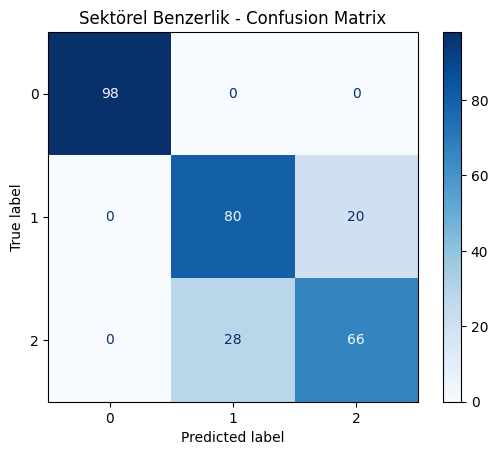

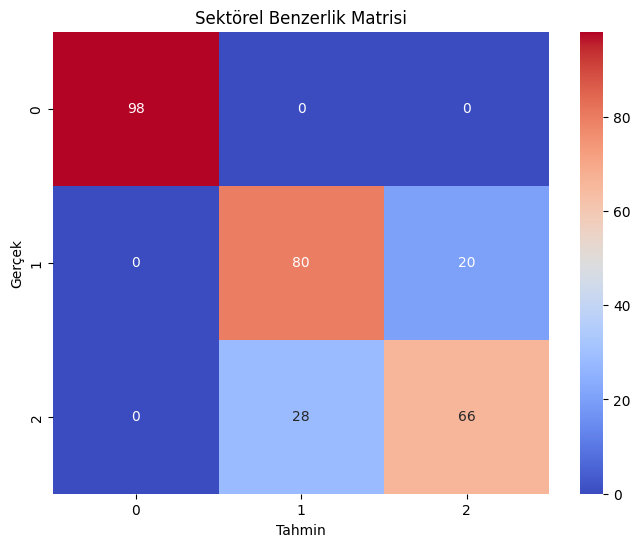

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = pd.read_csv("test_features.csv")
y_test = pd.read_csv("test_labels_encoded.csv").values.ravel()

X_test.drop(columns=[col for col in X_test.columns if "Unnamed" in col], inplace=True, errors="ignore")

#Kategorik Verileri Sayısala Çevirme
categorical_cols = X_test.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Kategorik Sütunlar Bulundu: {categorical_cols}")
    X_test = X_test.apply(pd.to_numeric, errors='coerce')  # Sayısal formatta olmayanları düzelt
    X_test.fillna(0, inplace=True)  # Eksik verileri sıfırla

best_xgb = joblib.load("optimized_XGBoost_model.pkl")
y_pred = best_xgb.predict(X_test)

#Confusion Matrix Oluşturma
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)

#Confusion Matrix Görselleştirme
plt.figure(figsize=(8,6))
display.plot(cmap='Blues', values_format='d')
plt.title("Sektörel Benzerlik - Confusion Matrix")
plt.show()

#Sektörel Benzerlik Analizi
sector_similarity = pd.crosstab(y_test, y_pred, rownames=['Gerçek'], colnames=['Tahmin'])

#Heatmap ile Görselleştirme
plt.figure(figsize=(8,6))
sns.heatmap(sector_similarity, annot=True, cmap='coolwarm', fmt='d')
plt.title("Sektörel Benzerlik Matrisi")
plt.show()

sector_similarity.to_csv("sector_similarity_matrix.csv")

In [ ]:
!pip install ta

## **5. Finansal Faktör Analizi**

- Ek olarak, momentum, volatilite, RSI, MACD, hareketli ortalamalar gibi finansal göstergeler hesaplanmış ve analize dahil edilmiştir.
- Bu faktörlerin modele etkisi incelenmiştir.

In [ ]:
import ta  # Teknik analiz kütüphanesi

df = pd.read_csv("tsfresh_ready_data.csv")

#Tarih Kolonunu DateTime Formatına Çevirme
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

#Teknik Göstergeleri Hesapla
price_column = "Return"

df["Momentum"] = df[price_column].pct_change(periods=10)  # 10 günlük momentum
df["Volatility"] = df[price_column].rolling(window=30).std()  # 30 günlük volatilite
df["RSI"] = ta.momentum.RSIIndicator(close=df[price_column], window=14).rsi()  # RSI hesaplama
df["MACD"] = ta.trend.MACD(df[price_column]).macd()  # MACD hesaplama
df["Signal"] = ta.trend.MACD(df[price_column]).macd_signal()  # MACD sinyal hattı
df["SMA_50"] = ta.trend.SMAIndicator(close=df[price_column], window=50).sma_indicator()  # 50 günlük hareketli ortalama
df["SMA_200"] = ta.trend.SMAIndicator(close=df[price_column], window=200).sma_indicator()  # 200 günlük hareketli ortalama

df.dropna(inplace=True)

df.to_csv("financial_factors.csv")

In [ ]:
import joblib

#Modelin Kullanacağı Özellik İsimlerini Kaydetme
joblib.dump(X_train.columns.tolist(), "model_features.pkl")

['model_features.pkl']

In [ ]:
loaded_model = joblib.load("optimized_XGBoost_model.pkl")
loaded_features = joblib.load("model_features.pkl")

#Örnek Yeni Bir Veri Oluşturalım (Gerçek Senaryoda Kullanıcıdan Gelecek)**
new_data = np.random.rand(1, len(loaded_features))  # 1 satır, tüm özellikler

new_data_df = pd.DataFrame(new_data, columns=loaded_features)

predicted_sector = loaded_model.predict(new_data_df)[0]

if predicted_sector == 0:
    predicted_sector = "Financials"
elif predicted_sector == 1:
    predicted_sector = "Healthcare"
elif predicted_sector == 2:
    predicted_sector = "Technology"

print(f"Modelin Tahmini: {predicted_sector}")

Modelin Tahmini: Technology


In [ ]:
loaded_model = joblib.load("optimized_XGBoost_model.pkl")
loaded_features = joblib.load("model_features.pkl")

num_real_estate_companies = 500  # Varsayımsal 50 şirket
real_estate_data = np.random.rand(num_real_estate_companies, len(loaded_features))

real_estate_df = pd.DataFrame(real_estate_data, columns=loaded_features)

real_estate_predictions = loaded_model.predict(real_estate_df)

#Çoğunlukla Hangi Sektöre Benzediğini Bulma
sector_counts = pd.Series(real_estate_predictions).value_counts()

#En Çok Benzediği Sektörü Belirleme
most_similar_sector = sector_counts.idxmax()

if most_similar_sector == 0:
    most_similar_sector = "Financials"
elif most_similar_sector == 1:
    most_similar_sector = "Healthcare"
elif most_similar_sector == 2:
    most_similar_sector = "Technology"

print("Real Estate Şirketlerinin En Çok Benzediği Sektörler:")
print(sector_counts)
print(f"En Çok Benzeyen Sektör: {most_similar_sector}")

Real Estate Şirketlerinin En Çok Benzediği Sektörler:
2    500
Name: count, dtype: int64
En Çok Benzeyen Sektör: Technology


## **6. Görselleştirme ve Sonuçlar**

### **6.1 Model Performans Görselleri**
- **Confusion Matrix**: Modelin doğru ve yanlış tahminlerinin görselleştirilmesi
- **Sektörel Benzerlik Analizi**: Sektörler arası benzerlik matrislerinin ısı haritası
- **Tahmin Edilen Sektör Dağılımı**: Modelin farklı sektörleri nasıl tahmin ettiğini gösteren bar grafikleri

### **6.2 Zaman Serisi Analizleri**
- **Hisse Getirileri Zaman Serisi Grafiği**
- **Momentum ve Volatilite Eğrileri**
- **Teknik Göstergelerin Karşılaştırmalı Görselleştirilmesi**


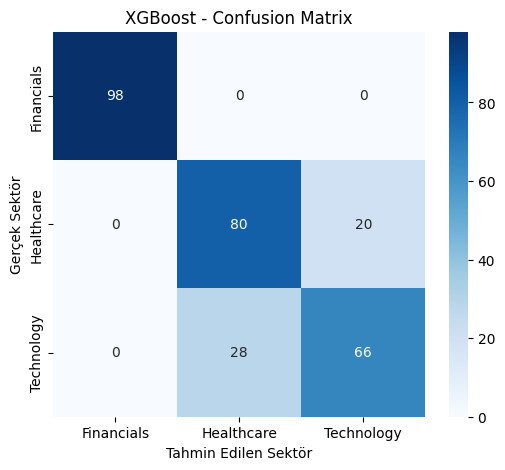

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = pd.read_csv("test_features.csv")
y_test = pd.read_csv("test_labels_encoded.csv").values.ravel()

X_test.drop(columns=[col for col in X_test.columns if "Unnamed" in col], inplace=True, errors="ignore")

best_xgb = joblib.load("optimized_XGBoost_model.pkl")
y_pred = best_xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
labels = ["Financials", "Healthcare", "Technology"]  # Modelin sınıflandırdığı sektörler

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin Edilen Sektör")
plt.ylabel("Gerçek Sektör")
plt.title("XGBoost - Confusion Matrix")
plt.show()

In [ ]:
# Dosyayı oku
sector_predictions = pd.read_csv("sector_similarity_matrix.csv")

# İlk birkaç satıra bakalım
print(sector_predictions.head())

   Gerçek   0   1   2
0       0  98   0   0
1       1   0  80  20
2       2   0  28  66


In [ ]:
print(sector_predictions.shape)
print(sector_predictions.columns)

(3, 4)
Index(['Gerçek', '0', '1', '2'], dtype='object')


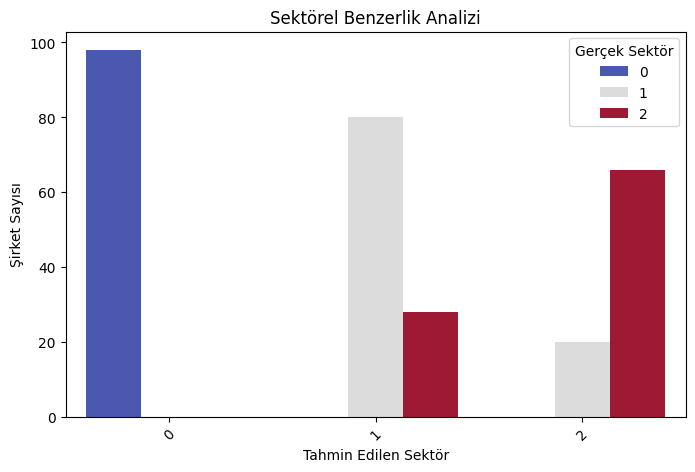

In [ ]:
#Sektör Tahminlerini Yükleme
sector_predictions = pd.read_csv("sector_similarity_matrix.csv")

#Sütun İsimlerini Sektör Adlarına Dönüştürme
sector_mapping = {0: "Financials", 1: "Healthcare", 2: "Technology"}
sector_predictions.rename(columns=sector_mapping, inplace=True)

#Veriyi Uzun (Melted) Hale Getirelim
sector_predictions_melted = sector_predictions.melt(id_vars=["Gerçek"], var_name="Tahmin Edilen Sektör", value_name="Şirket Sayısı")

#Görselleştirme
plt.figure(figsize=(8,5))
sns.barplot(x="Tahmin Edilen Sektör", y="Şirket Sayısı", hue="Gerçek", data=sector_predictions_melted, palette="coolwarm")
plt.xlabel("Tahmin Edilen Sektör")
plt.ylabel("Şirket Sayısı")
plt.title("Sektörel Benzerlik Analizi")
plt.xticks(rotation=45)
plt.legend(title="Gerçek Sektör")
plt.show()

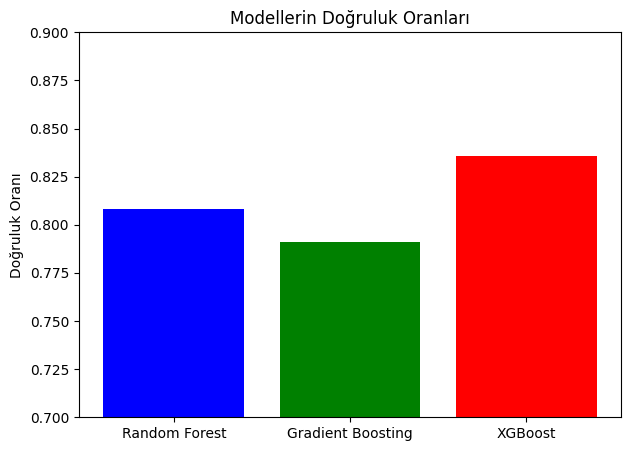

In [ ]:
models = ["Random Forest", "Gradient Boosting", "XGBoost"]
accuracies = [0.8082, 0.7911, 0.8356]  # Önceki eğitim sonuçlarından alınan doğruluk oranları

plt.figure(figsize=(7,5))
plt.bar(models, accuracies, color=["blue", "green", "red"])
plt.ylabel("Doğruluk Oranı")
plt.title("Modellerin Doğruluk Oranları")
plt.ylim(0.7, 0.9)
plt.show()

<ipython-input-18-398a937c13a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["SMA_50"] = stock_data["Return"].rolling(window=50).mean()
<ipython-input-18-398a937c13a1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data["SMA_200"] = stock_data["Return"].rolling(window=200).mean()


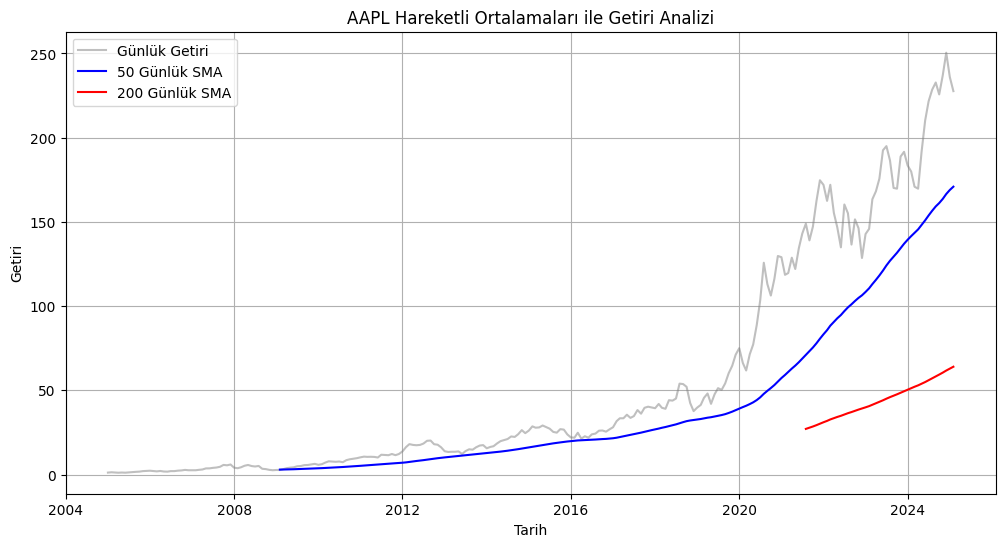

In [ ]:
#Şirket Seçelim
company_name = "AAPL"  # Örneğin Apple için
stock_data = df[df["Company"] == company_name]

#Ortalamaları Hesaplayalım
stock_data["SMA_50"] = stock_data["Return"].rolling(window=50).mean()
stock_data["SMA_200"] = stock_data["Return"].rolling(window=200).mean()

plt.figure(figsize=(12,6))
plt.plot(stock_data.index, stock_data["Return"], label="Günlük Getiri", color="gray", alpha=0.5)
plt.plot(stock_data.index, stock_data["SMA_50"], label="50 Günlük SMA", color="blue")
plt.plot(stock_data.index, stock_data["SMA_200"], label="200 Günlük SMA", color="red")

plt.xlabel("Tarih")
plt.ylabel("Getiri")
plt.title(f"{company_name} Hareketli Ortalamaları ile Getiri Analizi")
plt.legend()
plt.grid(True)
plt.show()

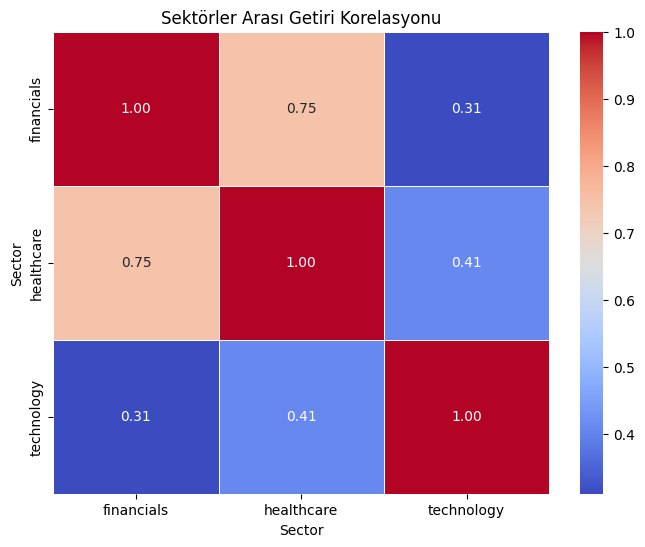

In [ ]:
#Sektör Bazında Getiri Korelasyonu
sector_correlation = df.pivot_table(index="Date", columns="Sector", values="Return").corr()

plt.figure(figsize=(8,6))
sns.heatmap(sector_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Sektörler Arası Getiri Korelasyonu")
plt.show()

## **7. Sonuç ve Gelecek Çalışmalar**

### **7.1 Modelin Başarısı ve Eksiklikleri**
Bu çalışmada geliştirilen model, %83.5 doğruluk oranı ile hisse senetlerini sektör bazında sınıflandırmada başarılı olmuştur. Ancak model, bazı sektörler arasında karışıklık yaşamaktadır.

### **7.2 Gelecekte Yapılabilecek İyileştirmeler**
- **Daha Fazla Faktör Eklenmesi**: Momentum, volatilite gibi ek finansal göstergelerle modelin daha güçlü hale getirilmesi.
- **Farklı Modellerin Entegrasyonu**: Transformer tabanlı modellerin test edilmesi.
- **Daha Büyük Veri Setleri ile Eğitim**: Daha fazla hisse senedi ile modelin güçlendirilmesi.
- **Gerçek Zamanlı Veri Kullanımı**: Modelin canlı piyasa verileri ile entegre edilmesi.

Bu çalışma, hisse senetlerinin zaman serisi verileri ile sektörel benzerliklerinin tahmin edilmesi konusunda önemli bir adımdır. Daha fazla veri ve model optimizasyonu ile daha güçlü tahminler yapılabilir.